# Denoising Pistachio Images Using Convolutional Autoencoder

## Library

In [41]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import random
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim

- Load all the required libraries

## Load Data

In [16]:
dataset_path= "B_23/"
image_files= sorted([f for f in os.listdir(dataset_path) if f.endswith('.jpg')])

- Sort the dataset to ensure everything is properly ordered

## EDA

In [17]:
shapes= []
for file in image_files:
  with Image.open(os.path.join(dataset_path, file)) as img:
    shapes.append(img.size)
        
print(f"Total Images: {len(image_files)}")
print(f"Unique Sizes: {set(shapes)}")

Total Images: 1074
Unique Sizes: {(600, 600)}


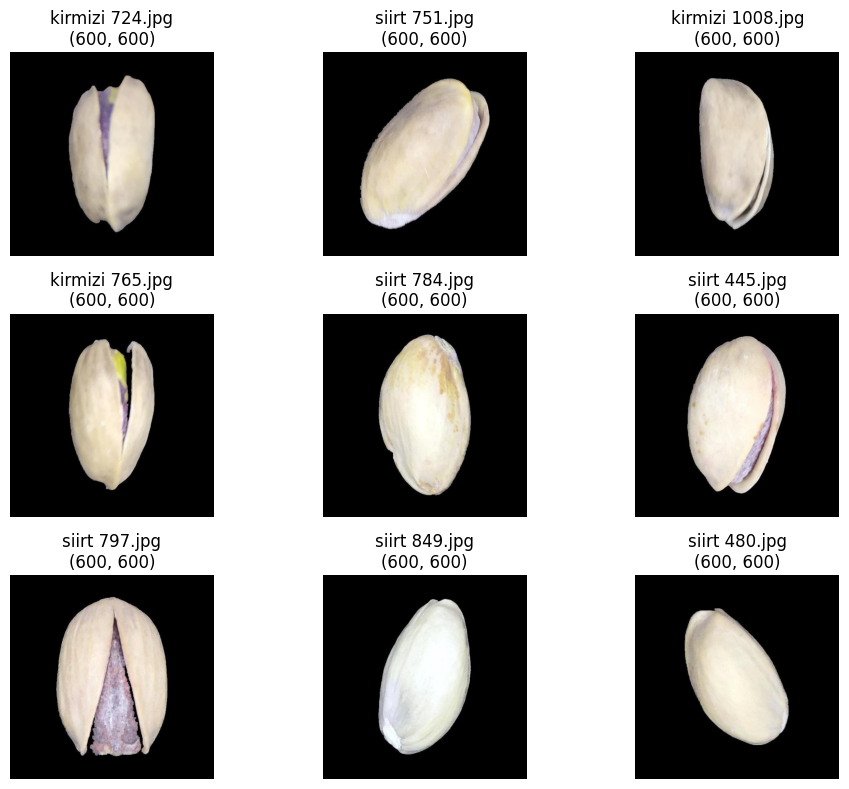

In [18]:
plt.figure(figsize= (10, 8))
sample_files = random.sample(image_files, 9)
for i in range(9):
  plt.subplot(3, 3, i + 1)
  img = Image.open(os.path.join(dataset_path, sample_files[i]))
  plt.imshow(img)
  plt.title(f"{sample_files[i]}\n{img.size}")
  plt.axis('off')
plt.tight_layout()
plt.show()

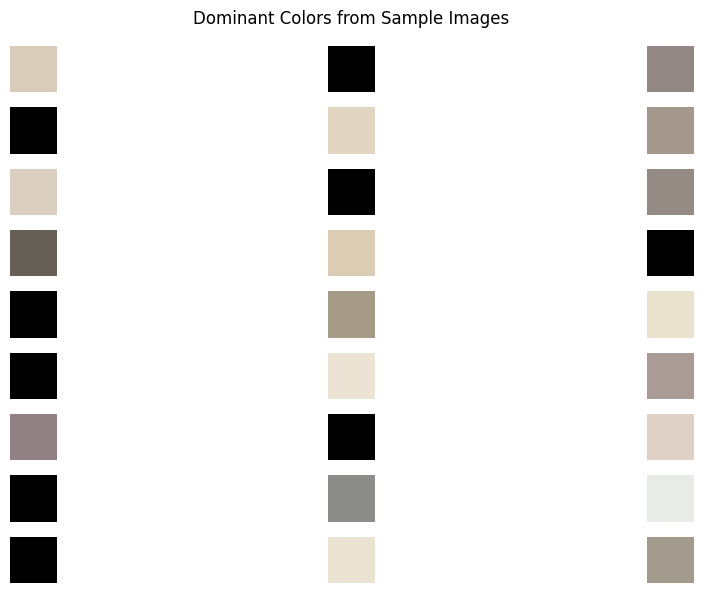

In [19]:
def get_dominant_color(img, k= 3):
  img= img.resize((50, 50))
  img_np= np.array(img).reshape(-1, 3)
  kmeans= KMeans(n_clusters=k)
  kmeans.fit(img_np)
  return kmeans.cluster_centers_.astype(int)

plt.figure(figsize=(12, 6))
for i in range(9):
  img = Image.open(os.path.join(dataset_path, sample_files[i]))
  colors = get_dominant_color(img, k=3)
  for j in range(3):
    plt.subplot(9, 3, i * 3 + j + 1)
    plt.imshow(np.ones((10, 10, 3), dtype=np.uint8) * colors[j])
    plt.axis('off')
plt.suptitle("Dominant Colors from Sample Images")
plt.tight_layout()
plt.show()

Type:
- kirmizi: 616 Images
- siirt: 458 Images


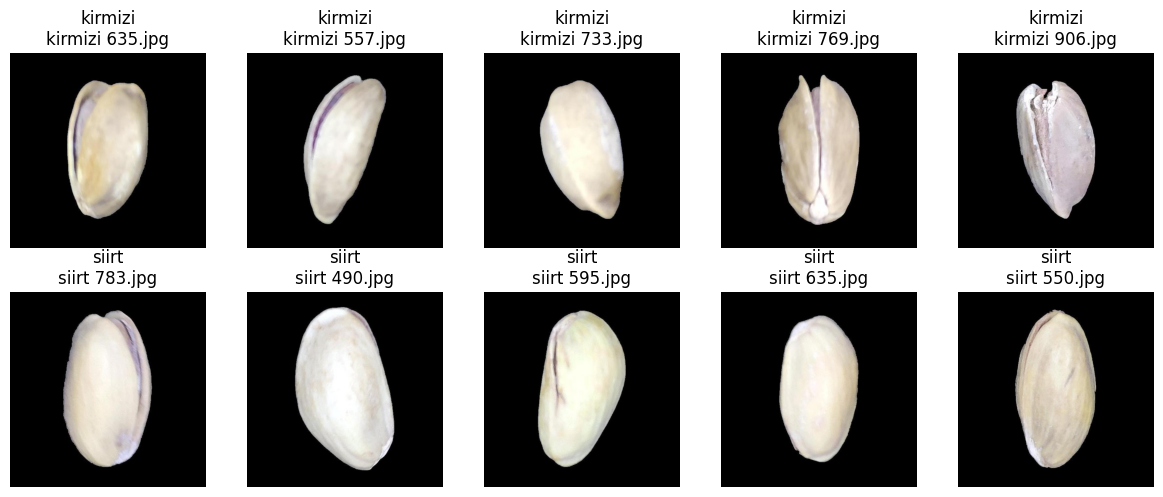

In [20]:
image_files= sorted([f for f in os.listdir(dataset_path) if f.endswith('.jpg')])

label_dict= defaultdict(list)
for file in image_files:
  label= file.split()[0].lower()
  label_dict[label].append(file)

print("Type:")
for label in label_dict:
  print(f"- {label}: {len(label_dict[label])} Images")

plt.figure(figsize=(12, len(label_dict)*2.5))
row= 0
for label, files in label_dict.items():
  samples= random.sample(files, min(5, len(files)))
  for i, file in enumerate(samples):
    img= Image.open(os.path.join(dataset_path, file))
    plt.subplot(len(label_dict), 5, row*5 + i + 1)
    plt.imshow(img)
    plt.title(f"{label}\n{file}")
    plt.axis('off')
  row += 1

plt.tight_layout()
plt.show()

## Preprocessing Data

### Split Data and Resize

In [21]:
def load_and_preprocess(image_path, target_size= (100, 100)):
  image= tf.io.read_file(image_path)
  image= tf.image.decode_jpeg(image, channels=3)
  image= tf.image.resize(image, target_size)
  image= tf.cast(image, tf.float32) / 255.0
  return image

In [22]:
image_paths= [os.path.join(dataset_path, f) for f in image_files]
dataset= tf.data.Dataset.from_tensor_slices(image_paths)
dataset= dataset.map(load_and_preprocess)

images= np.array(list(dataset.as_numpy_iterator()))

In [23]:
x_train, x_temp= train_test_split(images, test_size=0.2, random_state=42)
x_val, x_test= train_test_split(x_temp, test_size=0.5, random_state=42)

print(f"\nShape Data:")
print(f"Train: {x_train.shape} | Val: {x_val.shape} | Test: {x_test.shape}")


Shape Data:
Train: (859, 100, 100, 3) | Val: (107, 100, 100, 3) | Test: (108, 100, 100, 3)


### Add Noise to Image

In [24]:
def add_gaussian_noise(images, mean=0.0, std=0.1):
  noise= np.random.normal(mean, std, size= images.shape)
  noisy_images= images + noise
  return np.clip(noisy_images, 0.0, 1.0)

x_train_noisy= add_gaussian_noise(x_train)
x_val_noisy= add_gaussian_noise(x_val)
x_test_noisy= add_gaussian_noise(x_test)

- Add Gaussian noise to the training, validation, and test datasets to improve the model’s robustness and generalization. This is a common data augmentation technique used to simulate real world noise and prevent overfitting.

- The noise is generated from a normal distribution and added to the original data, then clipped to keep the values within the valid range [0.0, 1.0].

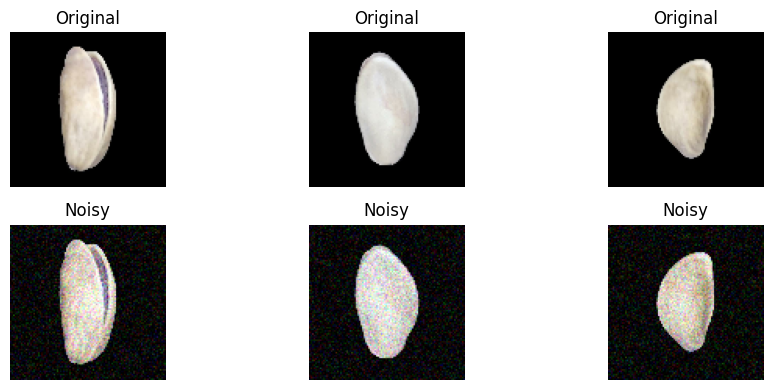

In [25]:
plt.figure(figsize= (10, 4))
for i in range(3):
  plt.subplot(2, 3, i+1)
  plt.imshow(x_train[i])
  plt.title("Original")
  plt.axis('off')
    
  plt.subplot(2, 3, i+4)
  plt.imshow(x_train_noisy[i])
  plt.title("Noisy")
  plt.axis('off')
plt.tight_layout()
plt.show()

## Model Baseline Autoencoder

In [26]:
def create_baseline_model(input_shape=(100, 100, 3)):
  inputs= Input(shape=input_shape)
    
  # Encoder
  x= Conv2D(32, (3, 3), activation= 'relu', padding= 'same')(inputs)
  x= MaxPooling2D((2, 2), padding= 'same')(x)
  x= Conv2D(64, (3, 3), activation= 'relu', padding= 'same')(x)
  x= MaxPooling2D((2, 2), padding= 'same')(x)
  x= Conv2D(64, (3, 3), activation= 'relu', padding= 'same')(x)
    
  # Decoder
  x= UpSampling2D((2, 2))(x)
  x= Conv2D(32, (3, 3), activation= 'relu', padding= 'same')(x)
  x= UpSampling2D((2, 2))(x)
  outputs= Conv2D(3, (3, 3), activation= 'sigmoid', padding= 'same')(x)
    
  model= Model(inputs, outputs)
  model.compile(optimizer= 'adam', loss= 'mse')
  return model

In [27]:
baseline_model= create_baseline_model()
baseline_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 25, 25, 64)        3692

### Training Baseline Model

In [28]:
history= baseline_model.fit(
  x_train_noisy, x_train,
  epochs= 100,
  batch_size= 8,
  validation_data= (x_val_noisy, x_val),
  callbacks= [
    tf.keras.callbacks.EarlyStopping(patience= 10, restore_best_weights= True),
    tf.keras.callbacks.ReduceLROnPlateau(factor= 0.5, patience= 5)
  ]
)

Epoch 1/100
108/108 [==============================] - 16s 19ms/step - loss: 0.0289 - val_loss: 0.0069 - lr: 0.0010
Epoch 2/100
108/108 [==============================] - 2s 15ms/step - loss: 0.0041 - val_loss: 0.0034 - lr: 0.0010
Epoch 3/100
108/108 [==============================] - 2s 15ms/step - loss: 0.0032 - val_loss: 0.0024 - lr: 0.0010
Epoch 4/100
108/108 [==============================] - 2s 15ms/step - loss: 0.0022 - val_loss: 0.0019 - lr: 0.0010
Epoch 5/100
108/108 [==============================] - 2s 15ms/step - loss: 0.0019 - val_loss: 0.0017 - lr: 0.0010
Epoch 6/100
108/108 [==============================] - 2s 15ms/step - loss: 0.0017 - val_loss: 0.0015 - lr: 0.0010
Epoch 7/100
108/108 [==============================] - 2s 15ms/step - loss: 0.0016 - val_loss: 0.0014 - lr: 0.0010
Epoch 8/100
108/108 [==============================] - 2s 15ms/step - loss: 0.0015 - val_loss: 0.0014 - lr: 0.0010
Epoch 9/100
108/108 [==============================] - 2s 15ms/step - loss: 0.0

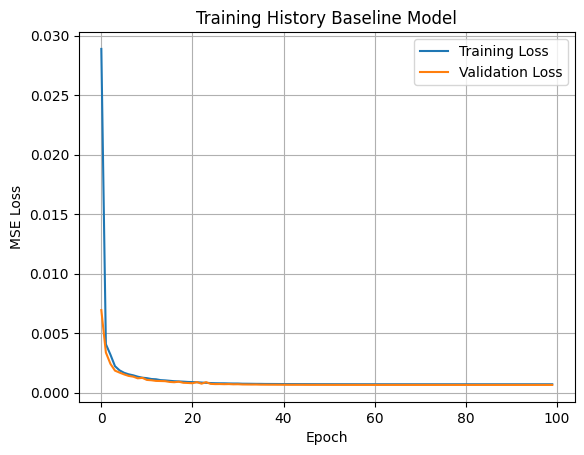

In [29]:
plt.plot(history.history['loss'], label= 'Training Loss')
plt.plot(history.history['val_loss'], label= 'Validation Loss')
plt.title('Training History Baseline Model')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

- The training and validation loss curves both decrease rapidly within the first few epochs and then flatten out near zero, indicating the model learns efficiently and reaches convergence.

- The close alignment between training and validation losses suggests minimal overfitting and strong generalization performance on unseen data.

## Modified Autoencoder Model

In [31]:
def create_modified_model(input_shape=(100, 100, 3)):
  inputs = Input(shape=input_shape)
    
  # Encoder
  x= Conv2D(32, (3, 3), activation= 'relu', padding= 'same')(inputs)
  x= Conv2D(32, (3, 3), activation= 'relu', padding= 'same')(x)
  x= MaxPooling2D((2, 2), padding= 'same')(x)
    
  x= Conv2D(64, (3, 3), activation= 'relu', padding= 'same')(x)
  x= Conv2D(64, (3, 3), activation= 'relu', padding= 'same')(x)
  x= MaxPooling2D((2, 2), padding= 'same')(x)
    
  x= Conv2D(128, (3, 3), activation= 'relu', padding= 'same')(x)
  x= Conv2D(128, (3, 3), activation= 'relu', padding= 'same')(x)
    
  # Decoder
  x= UpSampling2D((2, 2))(x)
  x= Conv2D(64, (3, 3), activation= 'relu', padding= 'same')(x)
  x= Conv2D(64, (3, 3), activation= 'relu', padding= 'same')(x)
    
  x= UpSampling2D((2, 2))(x)
  x= Conv2D(32, (3, 3), activation= 'relu', padding= 'same')(x)
  x= Conv2D(32, (3, 3), activation= 'relu', padding= 'same')(x)
    
  outputs= Conv2D(3, (3, 3), activation= 'sigmoid', padding= 'same')(x)
    
  model= Model(inputs, outputs)
  model.compile(optimizer= Adam(learning_rate=0.001), loss= 'mse')
  return model

In [32]:
modified_model= create_modified_model()
modified_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 64)        36928     
                                                           

### Training Modified Model

In [33]:
history_mod= modified_model.fit(
  x_train_noisy, x_train,
  epochs= 100,
  batch_size= 8,
  validation_data= (x_val_noisy, x_val),
  callbacks=[
    tf.keras.callbacks.EarlyStopping(patience= 10, restore_best_weights= True),
    tf.keras.callbacks.ReduceLROnPlateau(factor= 0.2, patience= 5, min_lr=0.00001)
  ]
)

Epoch 1/100
108/108 [==============================] - 7s 46ms/step - loss: 0.0208 - val_loss: 0.0036 - lr: 0.0010
Epoch 2/100
108/108 [==============================] - 4s 38ms/step - loss: 0.0033 - val_loss: 0.0028 - lr: 0.0010
Epoch 3/100
108/108 [==============================] - 4s 39ms/step - loss: 0.0028 - val_loss: 0.0026 - lr: 0.0010
Epoch 4/100
108/108 [==============================] - 4s 38ms/step - loss: 0.0023 - val_loss: 0.0018 - lr: 0.0010
Epoch 5/100
108/108 [==============================] - 4s 39ms/step - loss: 0.0018 - val_loss: 0.0016 - lr: 0.0010
Epoch 6/100
108/108 [==============================] - 4s 39ms/step - loss: 0.0017 - val_loss: 0.0015 - lr: 0.0010
Epoch 7/100
108/108 [==============================] - 4s 39ms/step - loss: 0.0014 - val_loss: 0.0011 - lr: 0.0010
Epoch 8/100
108/108 [==============================] - 4s 39ms/step - loss: 0.0012 - val_loss: 9.9874e-04 - lr: 0.0010
Epoch 9/100
108/108 [==============================] - 4s 39ms/step - loss: 

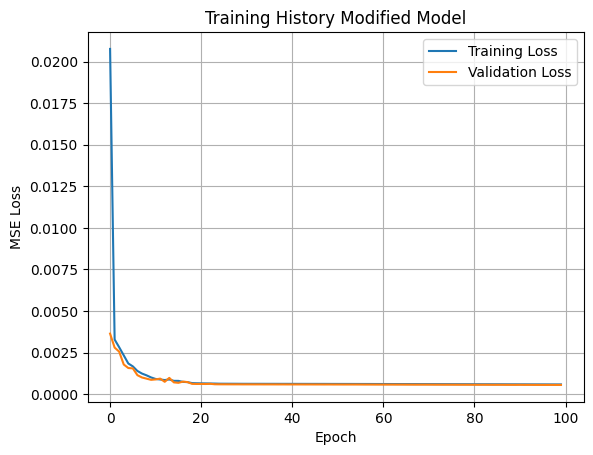

In [36]:
plt.plot(history_mod.history['loss'], label= 'Training Loss')
plt.plot(history_mod.history['val_loss'], label= 'Validation Loss')
plt.title('Training History Modified Model')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

- The modified model also shows a rapid decrease in both training and validation loss within the first few epochs, with both curves stabilizing at very low values, indicating strong learning capability.

- Compared to the baseline model, the modified model starts with a slightly higher initial loss but converges more smoothly and consistently, which suggests improved training stability and better generalization after introducing noise.

## Evaluation

In [42]:
def calculate_ssim(original, denoised):
  ssim_values= []
  for i in range(original.shape[0]):
    channel_ssim= []
    for ch in range(3):
      ch_ssim= ssim(original[i, ..., ch], 
                    denoised[i, ..., ch],
                    data_range=1.0)
      channel_ssim.append(ch_ssim)
    ssim_values.append(np.mean(channel_ssim))
  return np.mean(ssim_values)

In [43]:
baseline_pred= baseline_model.predict(x_test_noisy)
modified_pred= modified_model.predict(x_test_noisy)

4/4 [==============================] - 0s 39ms/step


In [44]:
baseline_ssim= calculate_ssim(x_test, baseline_pred)
modified_ssim= calculate_ssim(x_test, modified_pred)

In [45]:
print("\nEvaluation SSIM:")
print(f"Baseline Model: {baseline_ssim:.4f}")
print(f"Modified Model: {modified_ssim:.4f}")
print(f"Improvement: {(modified_ssim - baseline_ssim)*100:.2f}%")


Evaluation SSIM:
Baseline Model: 0.9534
Modified Model: 0.9579
Improvement: 0.46%


- The Structural Similarity Index (SSIM) for the modified model is **0.9579**, which is slightly higher than the baseline model's SSIM of **0.9534**.

- This **0.46% improvement** indicates that the modified model is better at preserving structural information in the data, leading to higher quality and more perceptually accurate predictions.

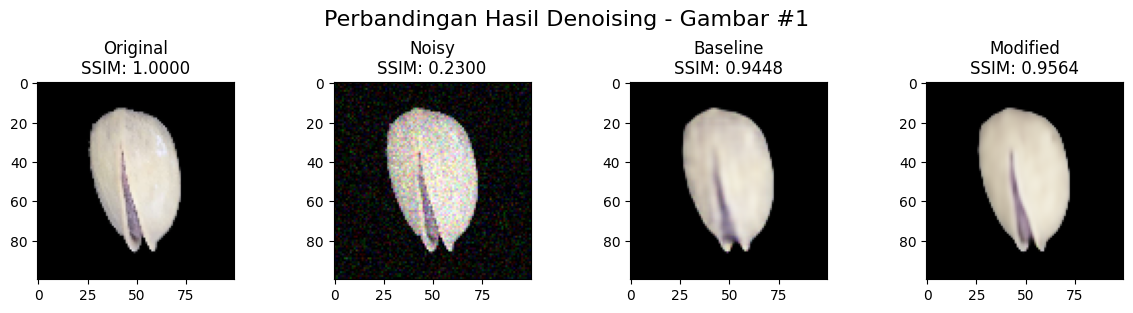

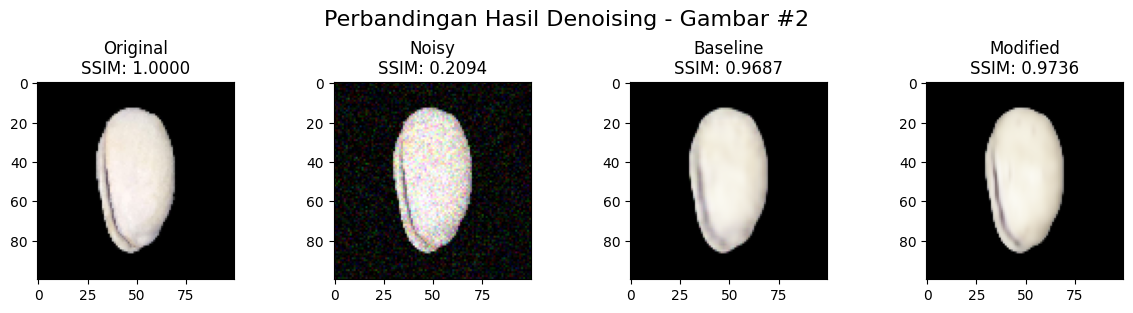

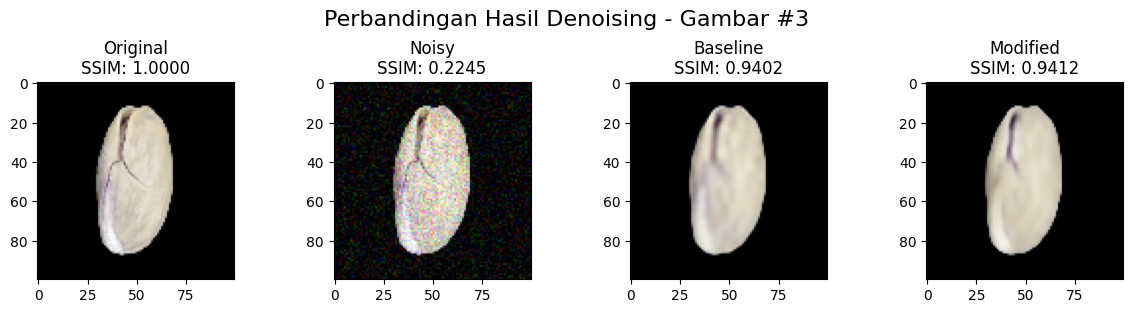

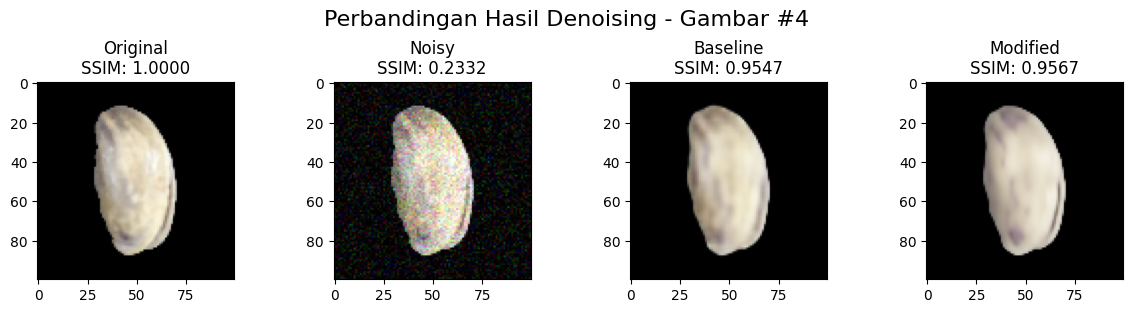

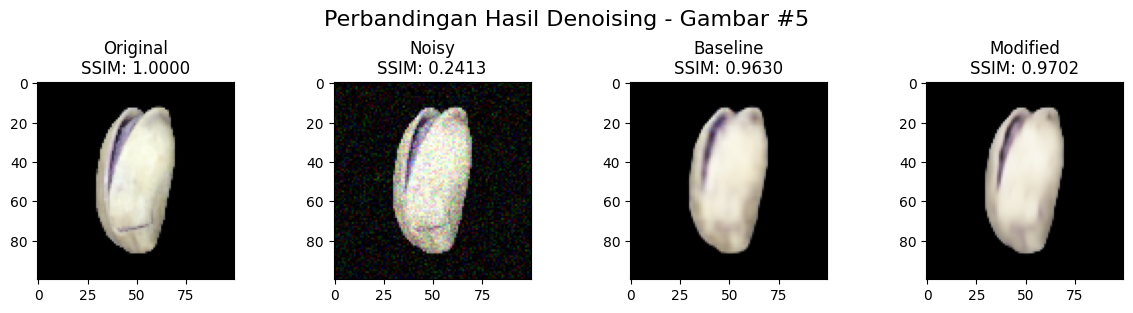

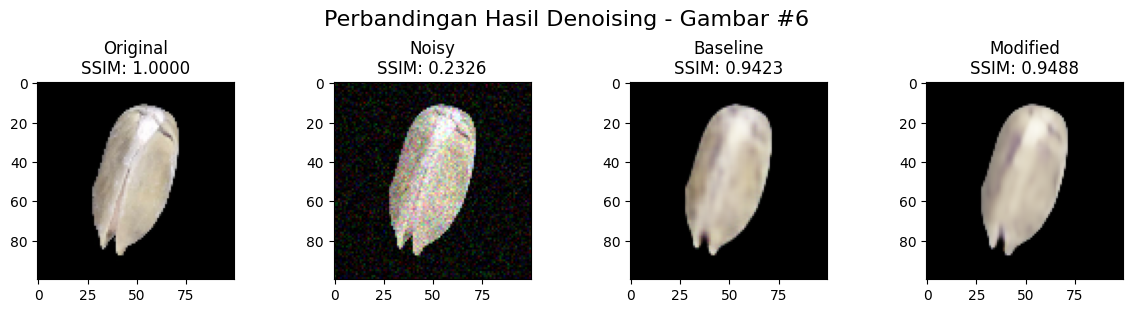

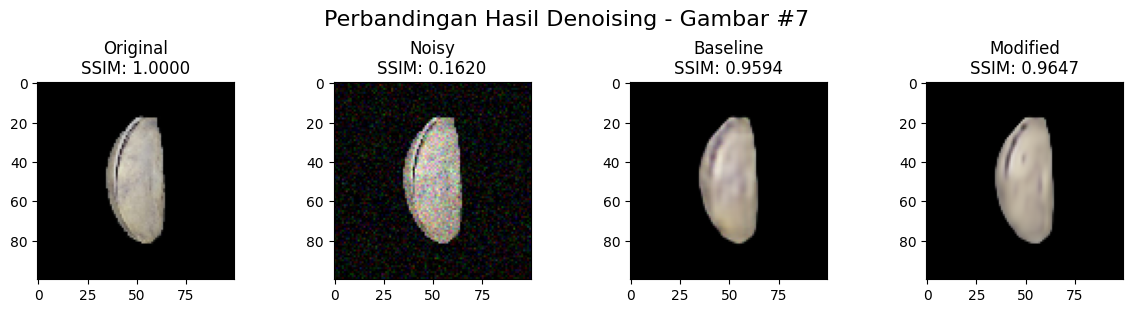

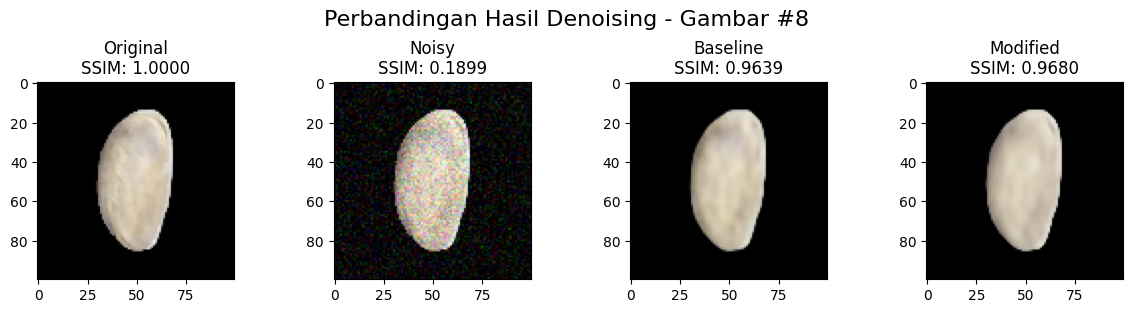

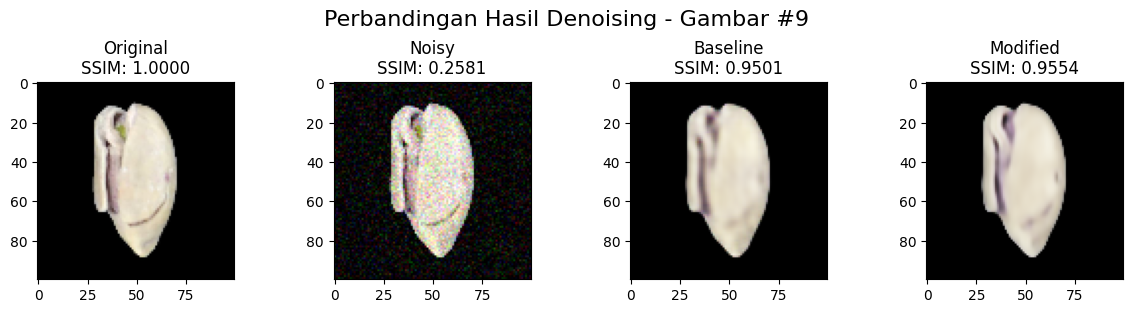

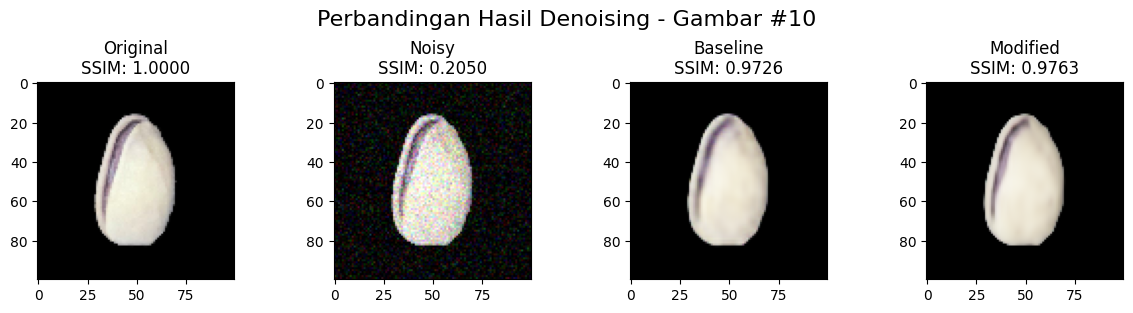

In [51]:
def plot_comparison(original, noisy, baseline, modified, idx):
  plt.figure(figsize=(12, 3))
    
  plt.subplot(1, 4, 1)
  plt.imshow(original)
  plt.title("Original\nSSIM: 1.0000")
    
  plt.subplot(1, 4, 2)
  plt.imshow(noisy)
  noisy_ssim= calculate_ssim(np.array([original]), np.array([noisy]))
  plt.title(f"Noisy\nSSIM: {noisy_ssim:.4f}")
    
  plt.subplot(1, 4, 3)
  plt.imshow(baseline)
  base_ssim= calculate_ssim(np.array([original]), np.array([baseline]))
  plt.title(f"Baseline\nSSIM: {base_ssim:.4f}")
    
  plt.subplot(1, 4, 4)
  plt.imshow(modified)
  mod_ssim= calculate_ssim(np.array([original]), np.array([modified]))
  plt.title(f"Modified\nSSIM: {mod_ssim:.4f}")
    
  plt.suptitle(f"Perbandingan Hasil Denoising - Gambar #{idx+1}", fontsize=16)
  plt.tight_layout()
  plt.show()

for i in range(0,10):
  plot_comparison(
    x_test[i], 
    x_test_noisy[i],
    baseline_pred[i],
    modified_pred[i],
    i
  )